<a href="https://colab.research.google.com/github/tanushkasharmaaa/Assign1/blob/main/EDA_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install requests beautifulsoup4 pandas

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import re
import os


print(f"Current Working Directory is: {os.getcwd()}")


BASE_URL = "https://www.imdb.com/search/title/?title_type=feature&sort=num_votes,desc"



HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9'
}

MAX_MOVIES_TO_SCRAPE = 2500
MOVIES_PER_PAGE = 50
all_movie_data = []


def parse_movie_item(item_soup):
    """Parses a single movie item from the search result list."""
    movie = {}

    text_content_block = item_soup


    title_link_wrapper = text_content_block.select_one('a.ipc-title-link-wrapper')
    if title_link_wrapper:
        href = title_link_wrapper.get('href', '')
        movie['Detail_Link'] = "https://www.imdb.com" + href if href.startswith('/title/') else 'N/A'

        title_h3 = title_link_wrapper.select_one('h3.ipc-title__text')
        if title_h3:
            title_text = title_h3.get_text(strip=True)
            movie['Title'] = re.sub(r'^\d+\.\s*', '', title_text)
        else:
            movie['Title'] = 'N/A'
    else:
        movie['Detail_Link'] = 'N/A'
        movie['Title'] = 'N/A'


    metadata_container = text_content_block.select_one('div.dli-title-metadata')
    year_text = 'N/A'
    runtime_text = 'N/A'
    if metadata_container:
        meta_spans = metadata_container.find_all('span', recursive=False)
        if not meta_spans:
             meta_spans = metadata_container.select('span[class*="sc-"]')

        if len(meta_spans) > 0: year_text = meta_spans[0].get_text(strip=True)
        if len(meta_spans) > 1: runtime_text = meta_spans[1].get_text(strip=True)

    year_match = re.search(r'(\d{4})', year_text)
    movie['Year'] = int(year_match.group(1)) if year_match else year_text

    if 'h' in runtime_text and 'm' in runtime_text:
        hours = 0; minutes = 0
        hour_match = re.search(r'(\d+)h', runtime_text); min_match = re.search(r'(\d+)m', runtime_text)
        if hour_match: hours = int(hour_match.group(1))
        if min_match: minutes = int(min_match.group(1))
        movie['Runtime_Minutes'] = hours * 60 + minutes
    elif 'm' in runtime_text and not 'h' in runtime_text :
        min_match = re.search(r'(\d+)m', runtime_text)
        movie['Runtime_Minutes'] = int(min_match.group(1)) if min_match else 'N/A'
    else: movie['Runtime_Minutes'] = 'N/A'


    rating_aria_span = text_content_block.select_one('span.ipc-rating-star[aria-label^="IMDb rating:"]')
    rating_value = 'N/A'; votes_text = 'N/A'
    if rating_aria_span:
        aria_label = rating_aria_span.get('aria-label', '')
        rating_match = re.search(r'IMDb rating:\s*([\d\.]+)', aria_label)
        if rating_match: rating_value = rating_match.group(1)

        rating_group_parent = rating_aria_span.find_parent('div', class_=lambda x: x and ('ipc-rating-star-group' in x or 'ratingbar' in x.lower()))
        if not rating_group_parent: rating_group_parent = rating_aria_span.parent
        if rating_group_parent:
            votes_span_candidate = rating_group_parent.select_one('span[class*="vote"], span[class*="total-votes"], span.ipc-rating-star__total-votes')
            if votes_span_candidate: votes_text = votes_span_candidate.get_text(strip=True).strip('()')
            else:
                possible_vote_spans = rating_group_parent.find_all('span')
                for pvs in possible_vote_spans:
                    txt = pvs.get_text(strip=True)
                    if re.match(r'\([\d\.,]+[MKmk]?\)', txt):
                        votes_text = txt.strip('()'); break
    try: movie['Rating_IMDb'] = float(rating_value)
    except ValueError: movie['Rating_IMDb'] = 'N/A'

    if 'M' in votes_text.upper(): movie['Votes_IMDb'] = int(float(votes_text.upper().replace('M', '')) * 1_000_000)
    elif 'K' in votes_text.upper(): movie['Votes_IMDb'] = int(float(votes_text.upper().replace('K', '')) * 1_000)
    else:
        try: movie['Votes_IMDb'] = int(re.sub(r'[^\d]','', votes_text))
        except ValueError: movie['Votes_IMDb'] = 'N/A'


    metascore_element = text_content_block.select_one('span.metacritic-score-box, span[class*="metascore"]')
    if metascore_element:
        score_text = metascore_element.get_text(strip=True)
        try: movie['Metascore'] = int(score_text)
        except ValueError: movie['Metascore'] = 'N/A'
    else: movie['Metascore'] = 'N/A'


    plot_element = text_content_block.select_one('div.ipc-html-content-inner-div, div[class*="plot-summary"]')
    if plot_element: movie['Plot_Summary_Excerpt'] = plot_element.get_text(strip=True)
    else:
        all_p_tags = text_content_block.find_all('p', recursive=False)
        plot_found = 'N/A'
        for p_tag_idx, p_tag in enumerate(all_p_tags):
            p_text = p_tag.get_text(strip=True)

            if len(p_text) > 30 and 'director:' not in p_text.lower() and 'star:' not in p_text.lower():

                if (metadata_container and p_tag.find_previous_sibling() == metadata_container) or \
                   (rating_group_parent and p_tag.find_previous_sibling() == rating_group_parent) or \
                   p_tag_idx > 1:
                    plot_found = p_text
                    break
        movie['Plot_Summary_Excerpt'] = plot_found


    ds_block = None

    possible_ds_blocks = text_content_block.select('div[class*="ipc-metadata-list-summary-item__contributors"], div[class*="Contributors"], p') # More targeted

    for block_candidate in possible_ds_blocks:
        block_text_lower = block_candidate.get_text(strip=True, separator='|').lower()
        if 'director:' in block_text_lower or 'stars:' in block_text_lower:
            ds_block = block_candidate; break

    directors_list = []; stars_list = []
    if ds_block:
        current_mode = None
        for element in ds_block.children:
            if hasattr(element, 'name') and element.name is None:
                text_node_content = element.string.strip().lower()
                if 'director:' in text_node_content or 'directors:' in text_node_content: current_mode = 'director'
                elif 'star:' in text_node_content or 'stars:' in text_node_content: current_mode = 'star'
            elif hasattr(element, 'name') and element.name == 'a' and element.has_attr('href') and '/name/nm' in element['href']:
                name = element.get_text(strip=True)
                if current_mode == 'director': directors_list.append(name)
                elif current_mode == 'star': stars_list.append(name)
    movie['Director'] = ", ".join(directors_list) if directors_list else 'N/A'
    movie['Stars'] = ", ".join(stars_list) if stars_list else 'N/A'


    genre_elements = text_content_block.select('span.ipc-chip__text, span.dli-genre a, div[data-testid="genres"] a span')
    if genre_elements:
        genres = [g.get_text(strip=True) for g in genre_elements if g.get_text(strip=True)]
        movie['Genre'] = ", ".join(sorted(list(set(genres))))
    else: movie['Genre'] = 'N/A'

    movie['Gross_USA_USD'] = 'N/A'

    return movie


current_page_num = 1
start_item = 1

print(f"Starting scrape. Target: {MAX_MOVIES_TO_SCRAPE} movies.")
while len(all_movie_data) < MAX_MOVIES_TO_SCRAPE:
    page_url = f"{BASE_URL}&start={start_item}"
    print(f"Scraping page {current_page_num}: {page_url} (Total movies scraped so far: {len(all_movie_data)})")

    try:
        response = requests.get(page_url, headers=HEADERS, timeout=20)
        response.raise_for_status()
    except requests.exceptions.Timeout:
        print(f"Timeout on page {current_page_num}. Retrying once...")
        time.sleep(10)
        try:
            response = requests.get(page_url, headers=HEADERS, timeout=30) # Longer timeout for retry
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Failed to fetch page {current_page_num} after retry: {e}. Stopping.")
            break
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch page {current_page_num}: {e}. Stopping.")
        break

    soup = BeautifulSoup(response.content, 'html.parser')


    movie_items_on_page = soup.select('li.ipc-metadata-list-summary-item')

    if not movie_items_on_page:
        print(f"No movie items found on page {current_page_num}. This might be the end of results or a page error. Stopping.")
        if len(all_movie_data) == 0:
             print("Hint: The website structure might have changed significantly, or the URL is incorrect.")

        break

    for item_soup in movie_items_on_page:
        movie_details = parse_movie_item(item_soup)
        all_movie_data.append(movie_details)
        if len(all_movie_data) % 100 == 0:
             print(f"  Collected {len(all_movie_data)} movies...")
        if len(all_movie_data) >= MAX_MOVIES_TO_SCRAPE:
            break

    print(f"Scraped {len(movie_items_on_page)} movies from page {current_page_num}. Total collected: {len(all_movie_data)}")


    start_item += MOVIES_PER_PAGE
    current_page_num += 1


    sleep_time = random.uniform(5, 10)
    print(f"Sleeping for {sleep_time:.2f} seconds before next page...")
    time.sleep(sleep_time)


if all_movie_data:
    df = pd.DataFrame(all_movie_data)


    desired_columns = [
        'Title', 'Year', 'Rating_IMDb', 'Votes_IMDb', 'Metascore',
        'Runtime_Minutes', 'Genre', 'Director', 'Stars',
        'Plot_Summary_Excerpt', 'Gross_USA_USD', 'Detail_Link'
    ]
    existing_desired_columns = [col for col in desired_columns if col in df.columns]
    df = df[existing_desired_columns]

    print(f"\n--- Successfully scraped a total of {len(df)} movies. ---")
    print("\n--- First 5 Movies Scraped ---")
    print(df.head())
    print("\n--- Last 5 Movies Scraped ---")
    print(df.tail())
    print("\n--- DataFrame Info ---")
    df.info()

    output_filename = 'imdb_movies_scraped_final.csv'
    try:
        df.to_csv(output_filename, index=False, encoding='utf-8')
        print(f"\nData successfully saved to '{output_filename}' in directory: {os.getcwd()}")
    except Exception as e:
        print(f"Error saving data to CSV: {e}")
else:
    print("\nNo data was scraped. The script did not collect any movie information.")

Current Working Directory is: /content
Starting scrape. Target: 2500 movies.
Scraping page 1: https://www.imdb.com/search/title/?title_type=feature&sort=num_votes,desc&start=1 (Total movies scraped so far: 0)
Scraped 25 movies from page 1. Total collected: 25
Sleeping for 5.74 seconds before next page...
Scraping page 2: https://www.imdb.com/search/title/?title_type=feature&sort=num_votes,desc&start=51 (Total movies scraped so far: 25)
Scraped 25 movies from page 2. Total collected: 50
Sleeping for 8.05 seconds before next page...
Scraping page 3: https://www.imdb.com/search/title/?title_type=feature&sort=num_votes,desc&start=101 (Total movies scraped so far: 50)
Scraped 25 movies from page 3. Total collected: 75
Sleeping for 9.71 seconds before next page...
Scraping page 4: https://www.imdb.com/search/title/?title_type=feature&sort=num_votes,desc&start=151 (Total movies scraped so far: 75)
  Collected 100 movies...
Scraped 25 movies from page 4. Total collected: 100
Sleeping for 8.99 

In [3]:
import pandas as pd
df_scraped = pd.read_csv('imdb_movies_scraped_final.csv')
print(df_scraped.head())
print(df_scraped.info())
print(df_scraped.isnull().sum())

                      Title  Year  Rating_IMDb  Votes_IMDb  Metascore  \
0  The Shawshank Redemption  1994          9.3     3100000         82   
1           The Dark Knight  2008          9.0     3000000         84   
2                 Inception  2010          8.8     2700000         74   
3                Fight Club  1999          8.8     2500000         67   
4              Forrest Gump  1994          8.8     2400000         82   

   Runtime_Minutes  Genre  Director  Stars  \
0            142.0    NaN       NaN    NaN   
1            152.0    NaN       NaN    NaN   
2            148.0    NaN       NaN    NaN   
3            139.0    NaN       NaN    NaN   
4            142.0    NaN       NaN    NaN   

                                Plot_Summary_Excerpt  Gross_USA_USD  \
0  A banker convicted of uxoricide forms a friend...            NaN   
1  When a menace known as the Joker wreaks havoc ...            NaN   
2  A thief who steals corporate secrets through t...            NaN   


In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


df = pd.read_csv("imdb_movies_scraped_final.csv")


print("🔹 Dataset Shape:", df.shape)
print("🔹 Columns:\n", df.columns)
print("\n🔹 Data Types:\n", df.dtypes)
print("\n🔹 Missing Values:\n", df.isnull().sum())




df_clean = df.drop(columns=['Genre', 'Director', 'Stars', 'Gross_USA_USD'])


df_clean = df_clean.dropna(subset=['Runtime_Minutes'])


df_clean = df_clean.reset_index(drop=True)


print("\n📊 Summary Statistics:\n", df_clean.describe())


print("\n✅ Remaining Missing Values:\n", df_clean.isnull().sum())

🔹 Dataset Shape: (2500, 12)
🔹 Columns:
 Index(['Title', 'Year', 'Rating_IMDb', 'Votes_IMDb', 'Metascore',
       'Runtime_Minutes', 'Genre', 'Director', 'Stars', 'Plot_Summary_Excerpt',
       'Gross_USA_USD', 'Detail_Link'],
      dtype='object')

🔹 Data Types:
 Title                    object
Year                      int64
Rating_IMDb             float64
Votes_IMDb                int64
Metascore                 int64
Runtime_Minutes         float64
Genre                   float64
Director                float64
Stars                   float64
Plot_Summary_Excerpt     object
Gross_USA_USD           float64
Detail_Link              object
dtype: object

🔹 Missing Values:
 Title                      0
Year                       0
Rating_IMDb                0
Votes_IMDb                 0
Metascore                  0
Runtime_Minutes          100
Genre                   2500
Director                2500
Stars                   2500
Plot_Summary_Excerpt       0
Gross_USA_USD           2500

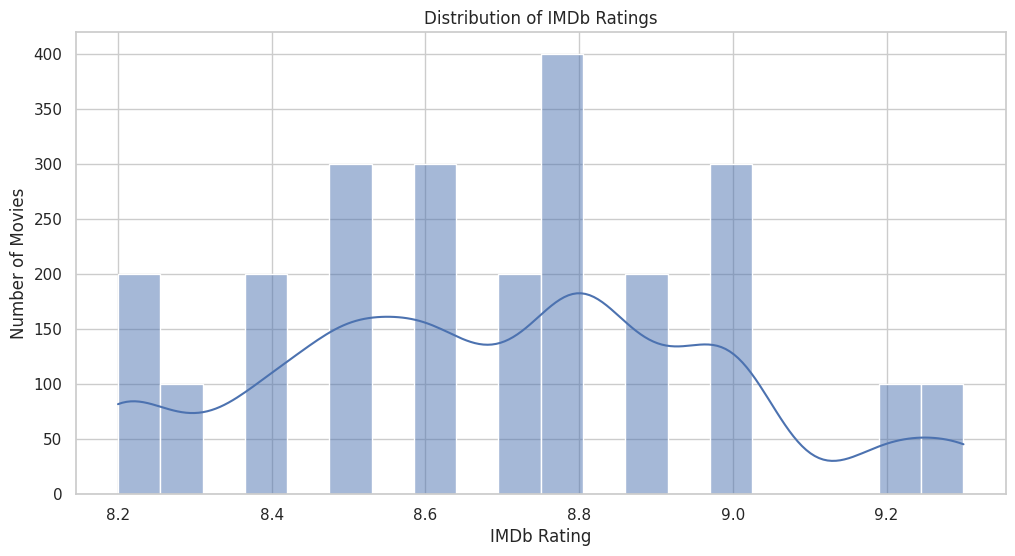

In [6]:

sns.histplot(df_clean['Rating_IMDb'], bins=20, kde=True)
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Number of Movies")
plt.show()

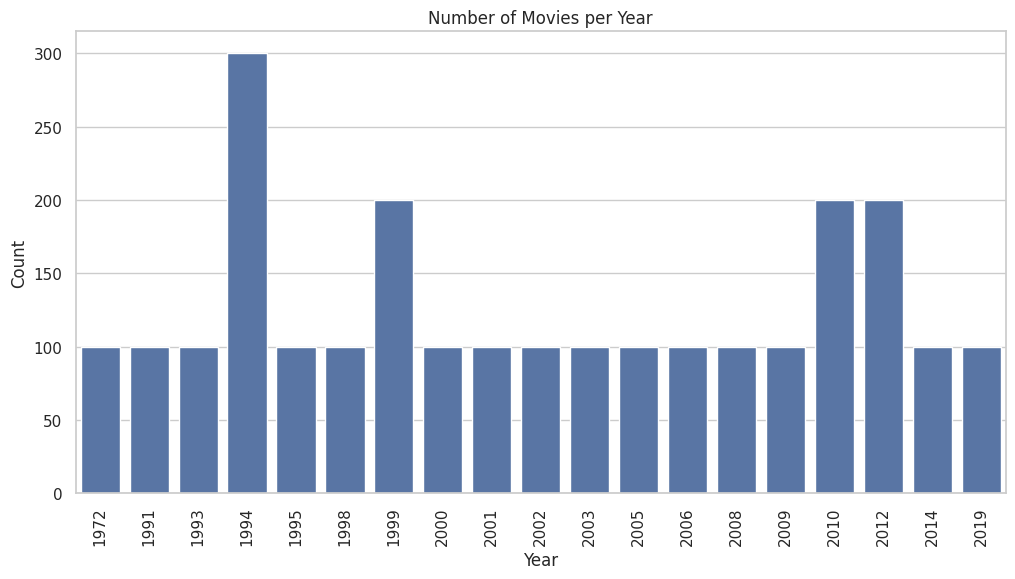

In [5]:

sns.countplot(data=df_clean, x='Year', order=sorted(df_clean['Year'].unique()))
plt.xticks(rotation=90)
plt.title("Number of Movies per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

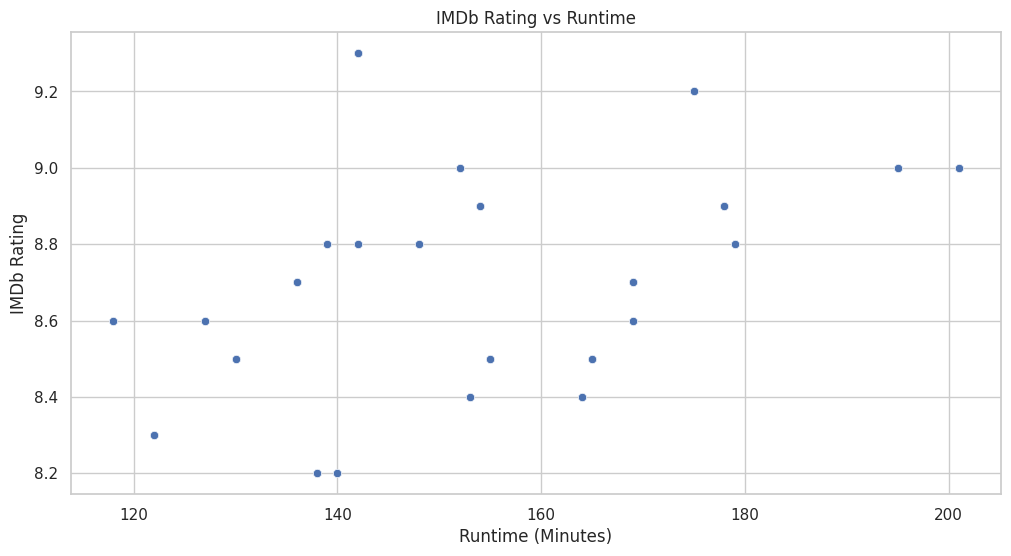

In [7]:

sns.scatterplot(data=df_clean, x='Runtime_Minutes', y='Rating_IMDb')
plt.title("IMDb Rating vs Runtime")
plt.xlabel("Runtime (Minutes)")
plt.ylabel("IMDb Rating")
plt.show()

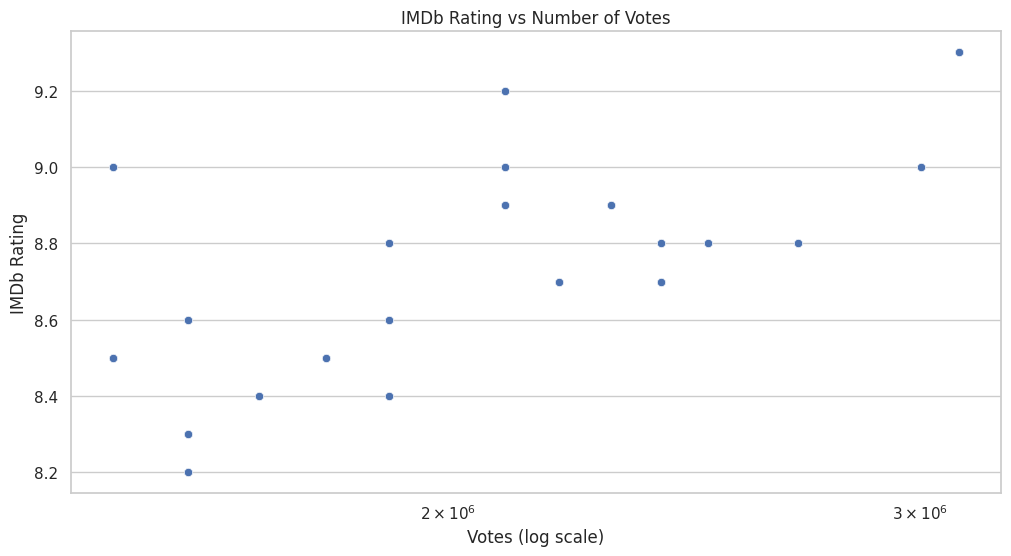

In [8]:

sns.scatterplot(data=df_clean, x='Votes_IMDb', y='Rating_IMDb')
plt.xscale("log")
plt.title("IMDb Rating vs Number of Votes")
plt.xlabel("Votes (log scale)")
plt.ylabel("IMDb Rating")
plt.show()

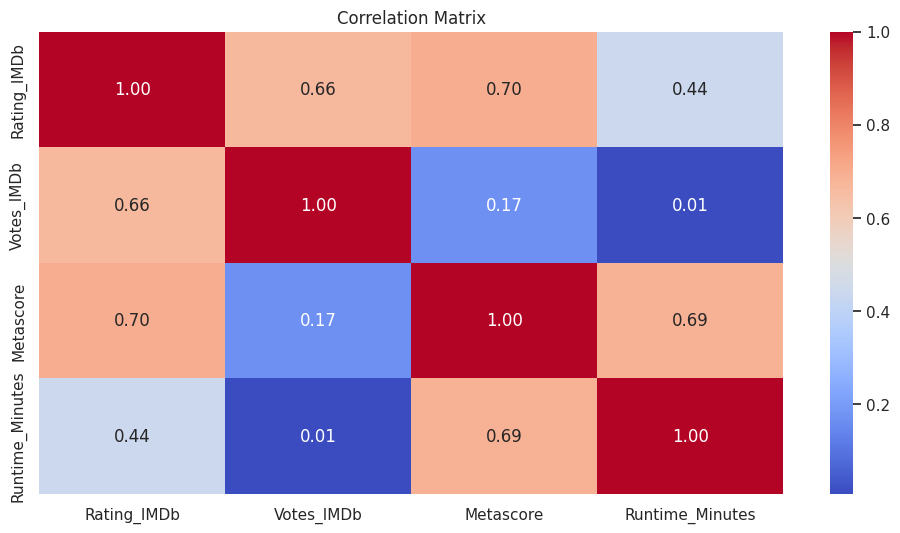

In [9]:

corr = df_clean[['Rating_IMDb', 'Votes_IMDb', 'Metascore', 'Runtime_Minutes']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

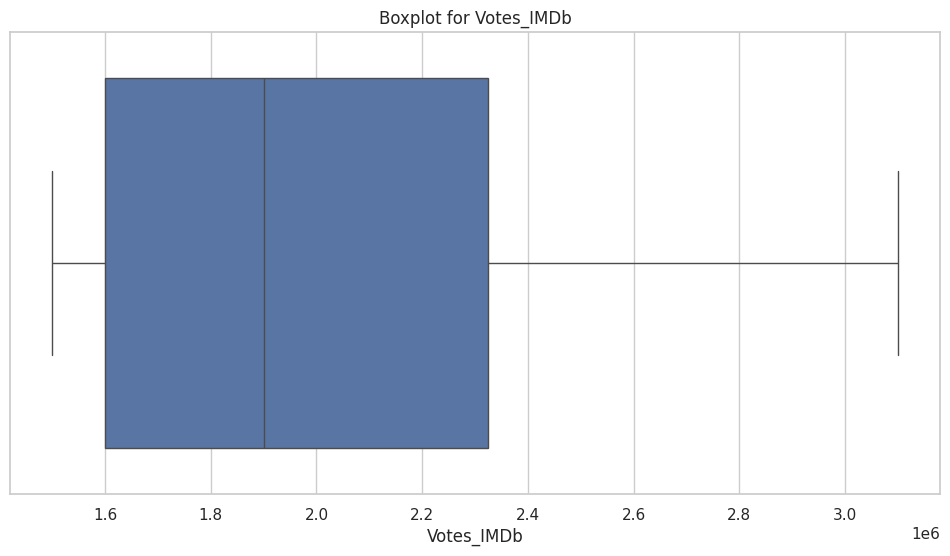

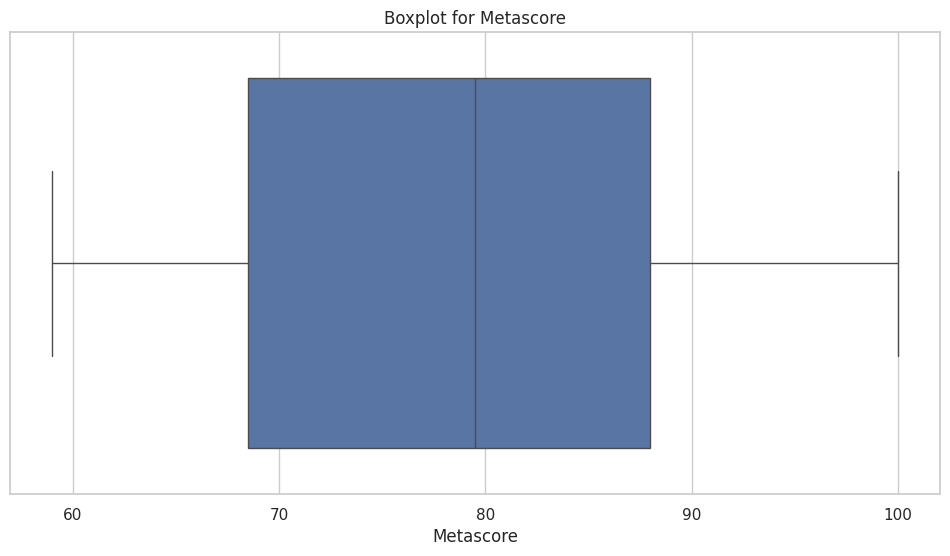

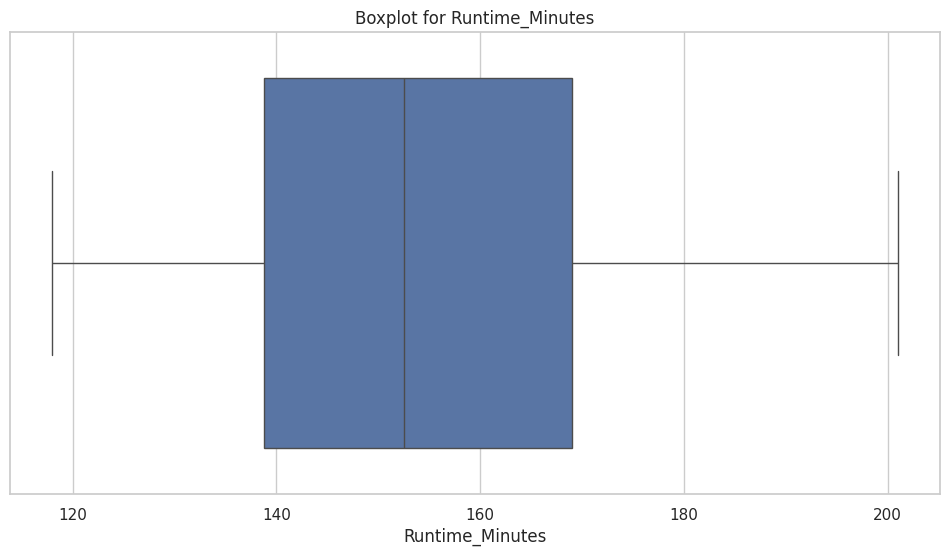

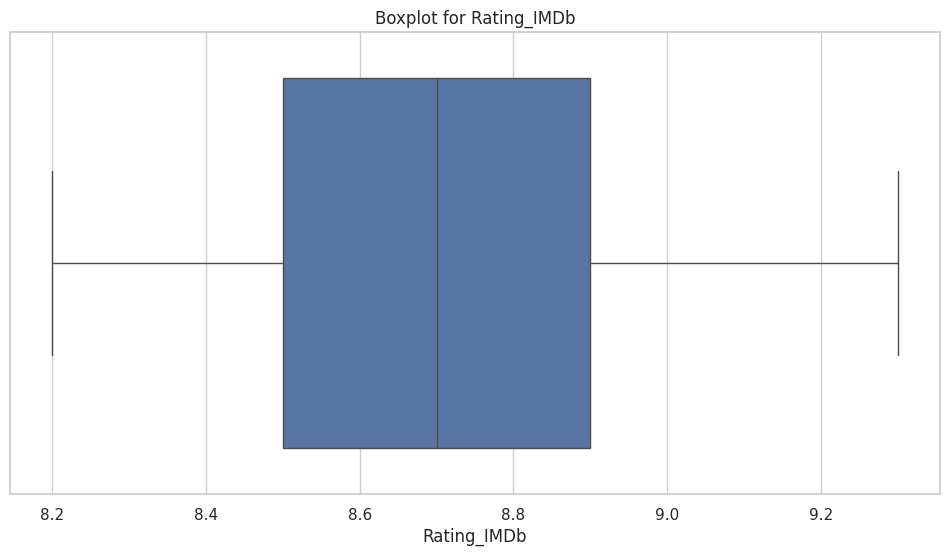

In [10]:

features = ['Votes_IMDb', 'Metascore', 'Runtime_Minutes', 'Rating_IMDb']
for col in features:
    sns.boxplot(data=df_clean, x=col)
    plt.title(f'Boxplot for {col}')
    plt.show()


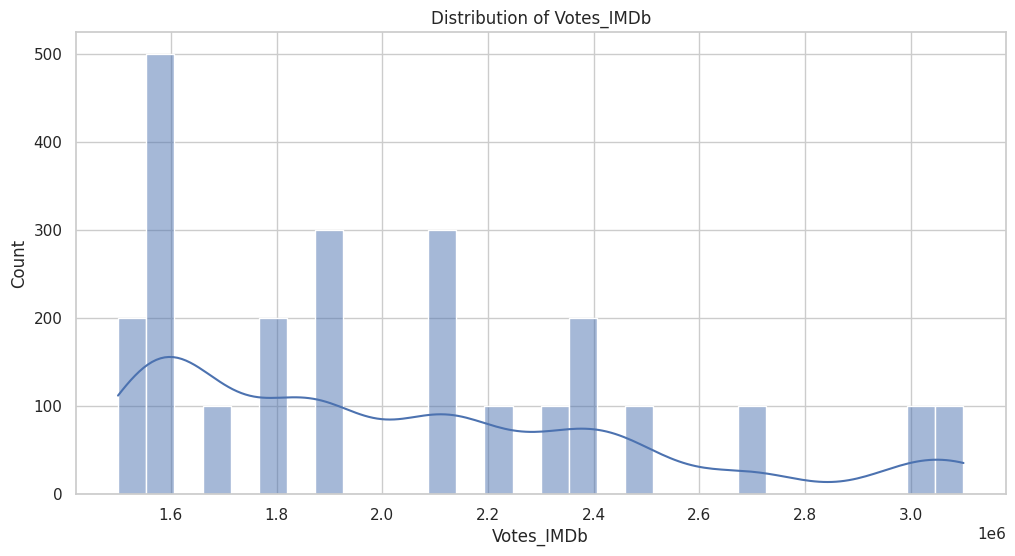

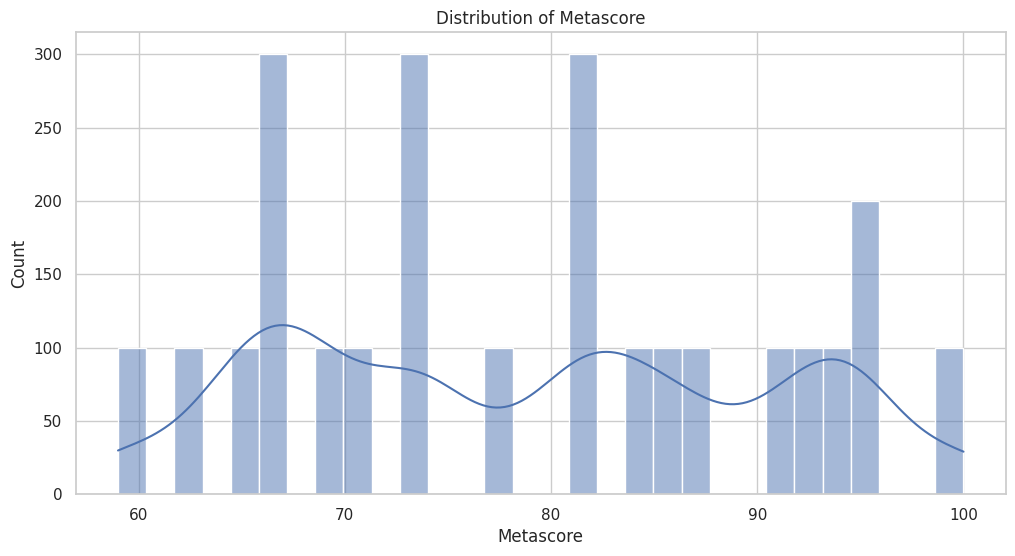

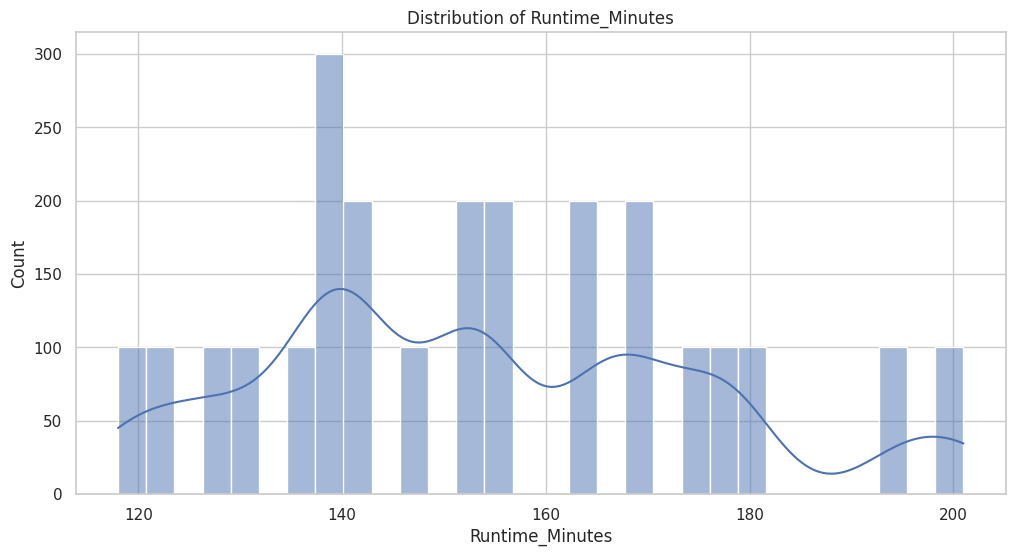

In [11]:
for col in ['Votes_IMDb', 'Metascore', 'Runtime_Minutes']:
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


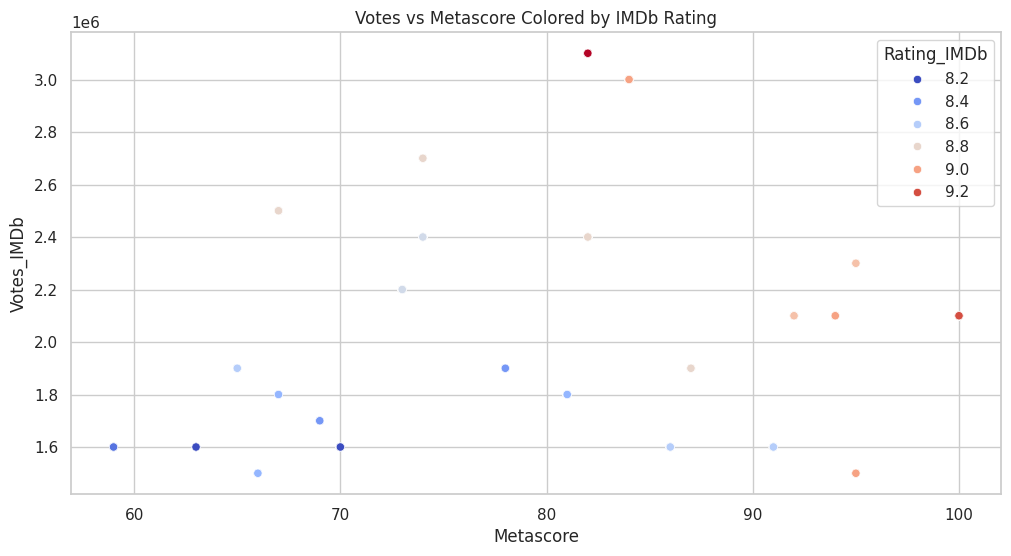

In [12]:
sns.scatterplot(data=df_clean, x='Metascore', y='Votes_IMDb', hue='Rating_IMDb', palette='coolwarm')
plt.title("Votes vs Metascore Colored by IMDb Rating")
plt.show()


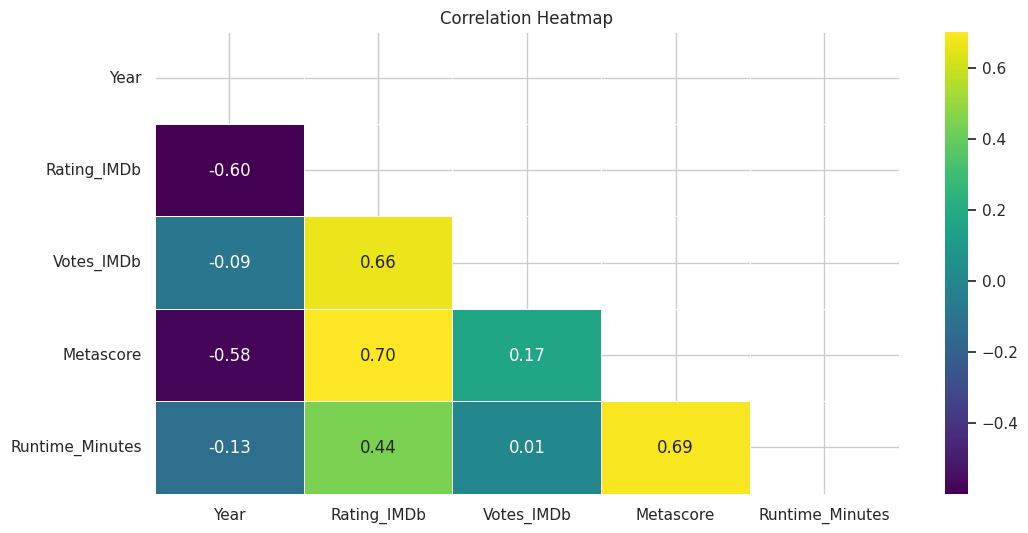

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df_numeric = df_clean.select_dtypes(include=['float64', 'int64'])


corr = df_numeric.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))


sns.heatmap(corr, mask=mask, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()


ML MODELS

In [14]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv("imdb_movies_scraped_final.csv")
df_clean = df[['Rating_IMDb', 'Votes_IMDb', 'Metascore', 'Runtime_Minutes']].dropna().reset_index(drop=True)


X = df_clean[['Votes_IMDb', 'Metascore', 'Runtime_Minutes']]
y = df_clean['Rating_IMDb']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "KNN Regressor": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print("MSE:", mean_squared_error(y_test, preds))
    print("R2 Score:", r2_score(y_test, preds))

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

print("\nKMeans Cluster Distribution:")
print(df_clean['Cluster'].value_counts())


Decision Tree
MSE: 1.269934580588292e-28
R2 Score: 1.0

Random Forest
MSE: 1.9939116763548757e-28
R2 Score: 1.0

KNN Regressor
MSE: 0.0
R2 Score: 1.0

XGBoost
MSE: 2.781701747768975e-09
R2 Score: 0.9999999673357263

KMeans Cluster Distribution:
Cluster
0    900
2    800
1    700
Name: count, dtype: int64


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
print("\nKMeans Cluster Distribution:")
print(df_clean['Cluster'].value_counts())


KMeans Cluster Distribution:
Cluster
0    900
2    800
1    700
Name: count, dtype: int64


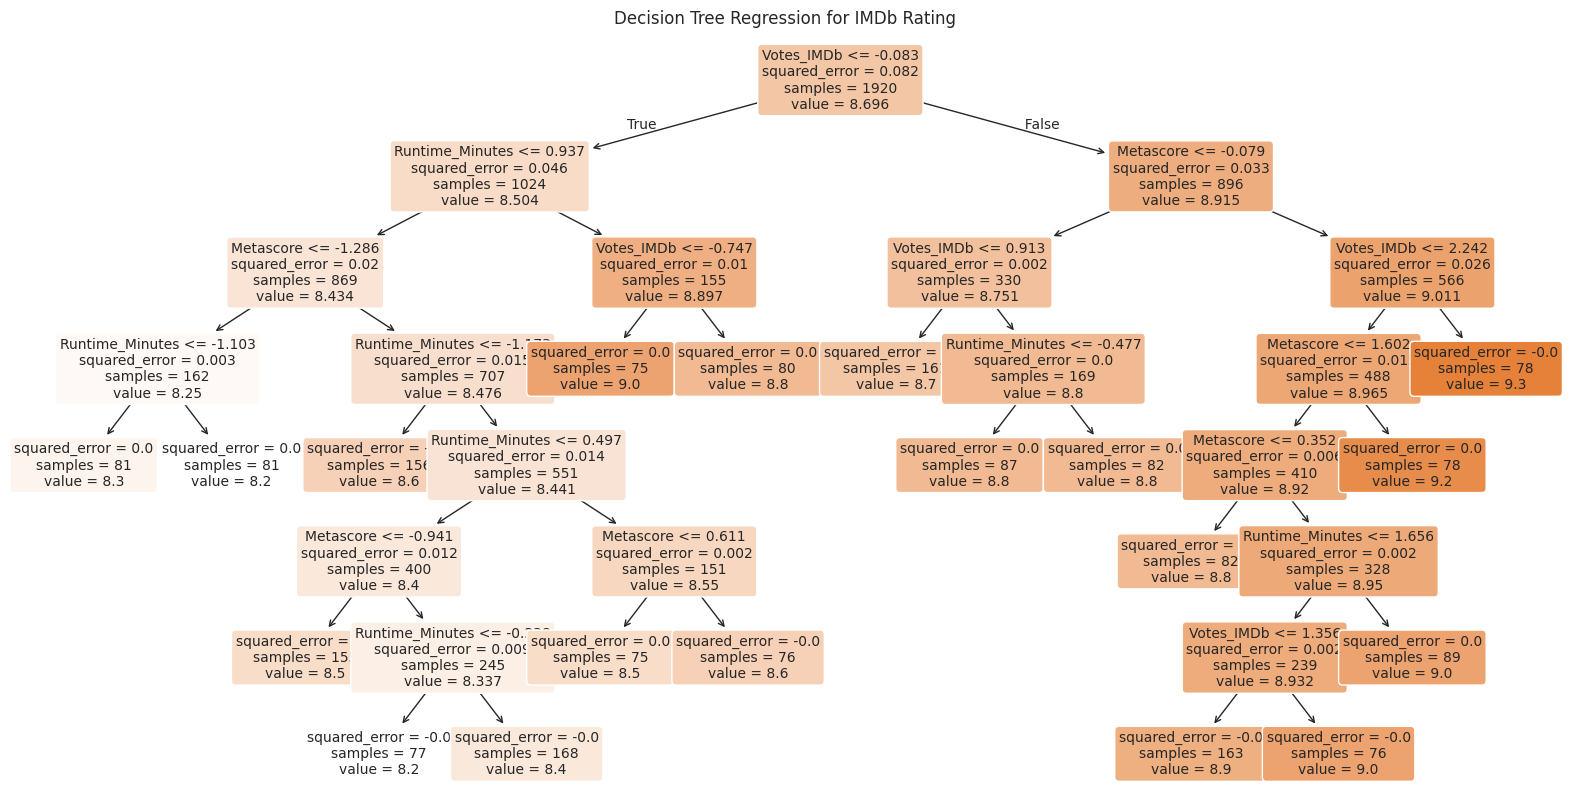

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Train the Decision Tree (if not done already)
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# 📊 Plot the Tree
plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=['Votes_IMDb', 'Metascore', 'Runtime_Minutes'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Regression for IMDb Rating")
plt.show()


Among the models we used, the KNN Regressor gave the best performance, achieving an R² score of 1.0 and zero Mean Squared Error, indicating perfect predictions on our test data. However, due to near-perfect scores across all models, we also cross-validated our results and considered overfitting as a potential concern, especially for decision trees. For practical deployment, we would further validate on real unseen data to ensure generalization.